In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
from itertools import product
warnings.filterwarnings("ignore")
pd.plotting.register_matplotlib_converters()
%matplotlib inline

In [67]:
app_train = pd.read_csv('train_set.csv')
app_test = pd.read_csv('test_set.csv')

In [68]:
app_train.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,43,management,married,tertiary,no,291,yes,no,unknown,9,may,150,2,-1,0,unknown,0
1,2,42,technician,divorced,primary,no,5076,yes,no,cellular,7,apr,99,1,251,2,other,0
2,3,47,admin.,married,secondary,no,104,yes,yes,cellular,14,jul,77,2,-1,0,unknown,0
3,4,28,management,single,secondary,no,-994,yes,yes,cellular,18,jul,174,2,-1,0,unknown,0
4,5,42,technician,divorced,secondary,no,2974,yes,no,unknown,21,may,187,5,-1,0,unknown,0


In [71]:
app_train.describe()

,ID,age,balance,day,duration,campaign,pdays,previous,y
count,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000
mean,12659.000000,40.935379,1357.555082,15.835289,257.732393,2.772050,40.248766,0.591737,0.116957
std,7308.532719,10.634289,2999.822811,8.319480,256.975151,3.136097,100.213541,2.568313,0.321375
min,1.000000,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,6330.000000,33.000000,73.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,12659.000000,39.000000,448.000000,16.000000,181.000000,2.000000,-1.000000,0.000000,0.000000
75%,18988.000000,48.000000,1435.000000,21.000000,317.000000,3.000000,-1.000000,0.000000,0.000000
max,25317.000000,95.000000,102127.000000,31.000000,3881.000000,55.000000,854.000000,275.000000,1.000000


In [69]:
#找出对象特征和数值特征
numerical_fea = list(app_train.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(app_train.columns)))
label = 'y'
numerical_fea.remove(label)

In [48]:
#空缺值检测,无空缺值

In [ ]:
#用均方差进行异常值探索和处理

In [70]:
def find_outliers_by_3segama(data,fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x:str('异常值') if x > upper_rule or x < lower_rule else '正常值')
    return data

In [72]:
data_train = app_train.copy()
for fea in numerical_fea:
    data_train = find_outliers_by_3segama(data_train,fea)
    print(data_train[fea+'_outliers'].value_counts())
    print(data_train.groupby(fea+'_outliers')['y'].sum())
    print('*'*10)

正常值    25317
Name: ID_outliers, dtype: int64
ID_outliers
正常值    2961
Name: y, dtype: int64
**********
正常值    25093
异常值      224
Name: age_outliers, dtype: int64
age_outliers
异常值     104
正常值    2857
Name: y, dtype: int64
**********
正常值    24906
异常值      411
Name: balance_outliers, dtype: int64
balance_outliers
异常值      63
正常值    2898
Name: y, dtype: int64
**********
正常值    25317
Name: day_outliers, dtype: int64
day_outliers
正常值    2961
Name: y, dtype: int64
**********
正常值    24773
异常值      544
Name: duration_outliers, dtype: int64
duration_outliers
异常值     332
正常值    2629
Name: y, dtype: int64
**********
正常值    24835
异常值      482
Name: campaign_outliers, dtype: int64
campaign_outliers
异常值      16
正常值    2945
Name: y, dtype: int64
**********
正常值    24337
异常值      980
Name: pdays_outliers, dtype: int64
pdays_outliers
异常值     158
正常值    2803
Name: y, dtype: int64
**********
正常值    25055
异常值      262
Name: previous_outliers, dtype: int64
previous_outliers
异常值      63
正常值    2898
Name: y, dt

In [73]:
#删除异常值
for fea in numerical_fea:
    train = train[data_train[fea+'_outliers']=='正常值']
    train = train.reset_index(drop=True) 

In [50]:
#特征转化

In [74]:
#将月份由英文转为数字
app_train['month'].value_counts()

may    7655
jul    3937
aug    3482
jun    2968
nov    2243
apr    1669
feb    1464
jan     777
oct     411
sep     339
mar     269
dec     103
Name: month, dtype: int64

In [75]:
month_num_map = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
app_train['month'] = app_train['month'].apply(lambda x:month_num_map[x])

In [53]:
#购买用户画像探索

In [54]:
def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = app_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = app_train[[feature, 'y']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='y', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='y', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of y with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

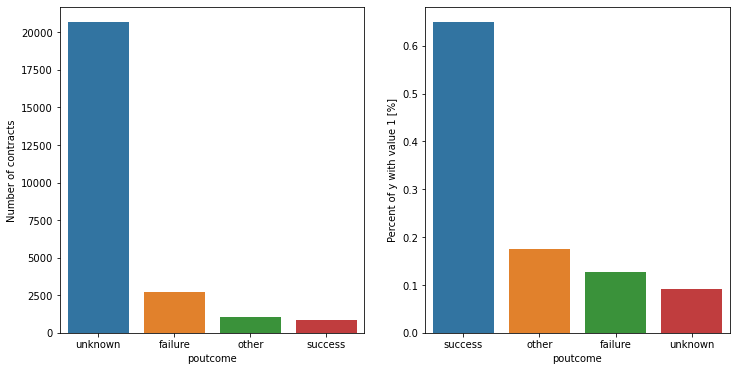

In [39]:
plot_stats('poutcome')

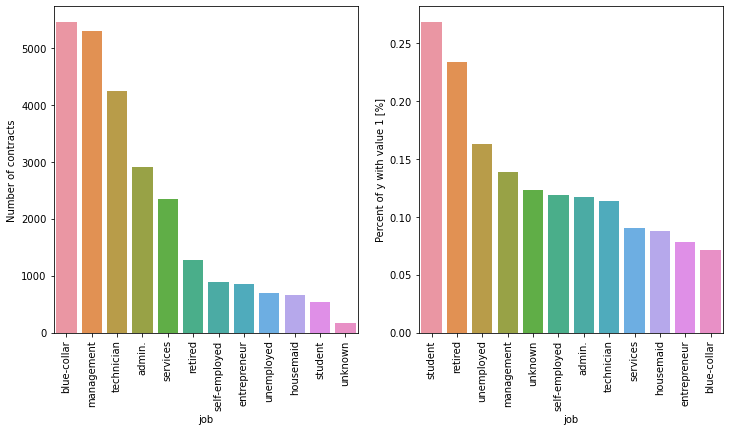

In [13]:
plot_stats('job',True) #可以看出学生购买比例最高

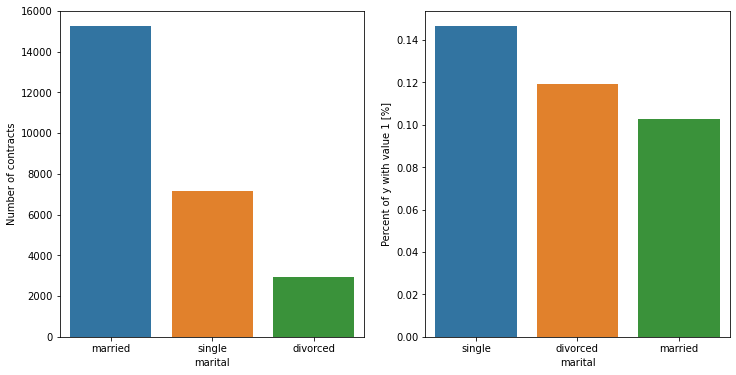

In [14]:
plot_stats('marital')#单身人群购买比例最高

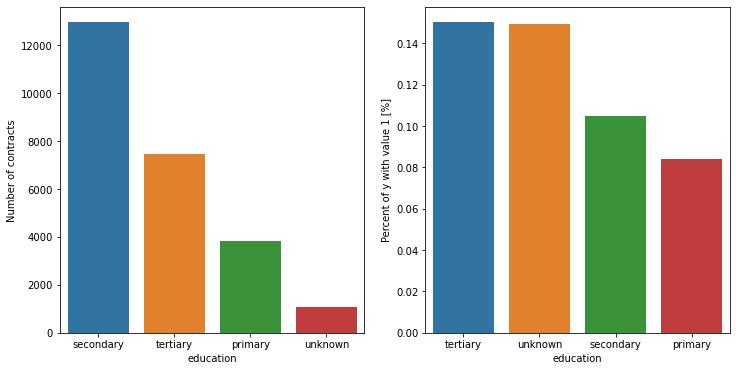

In [15]:
plot_stats('education')

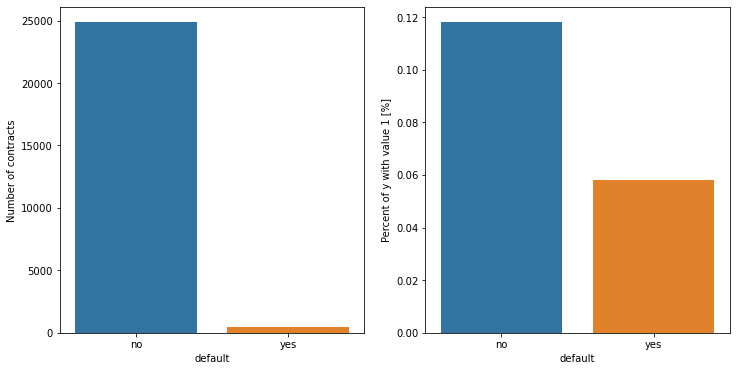

In [16]:
plot_stats('default')

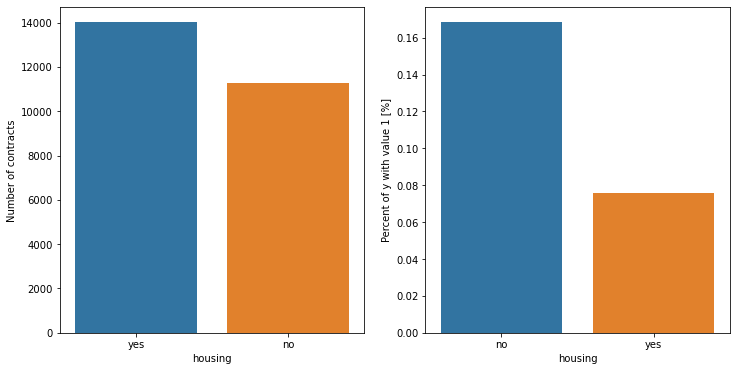

In [17]:
plot_stats('housing')#没有住房贷款的用户，购买比例更高

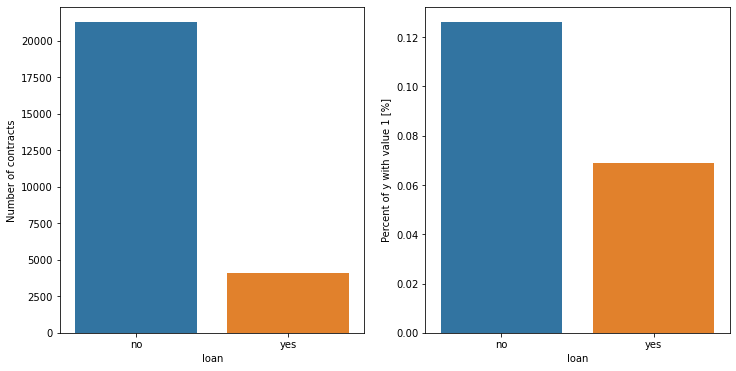

In [18]:
plot_stats('loan')#没有贷款的人，购买比例更高

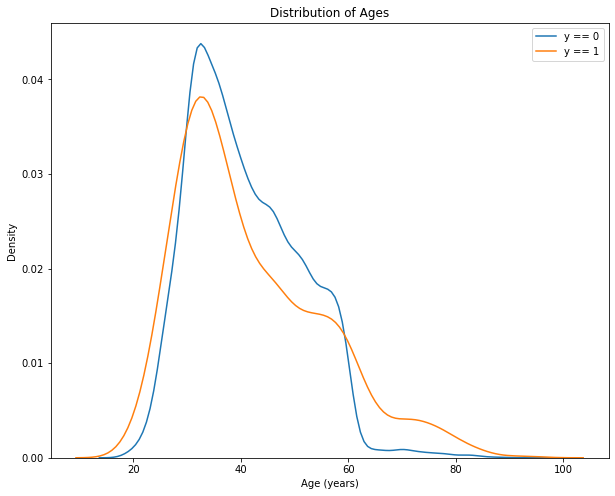

In [19]:
#查看不同年龄的购买情况
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['y'] == 0, 'age'], label = 'y == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['y'] == 1, 'age'], label = 'y == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

#可以看出年轻人的购买率更高

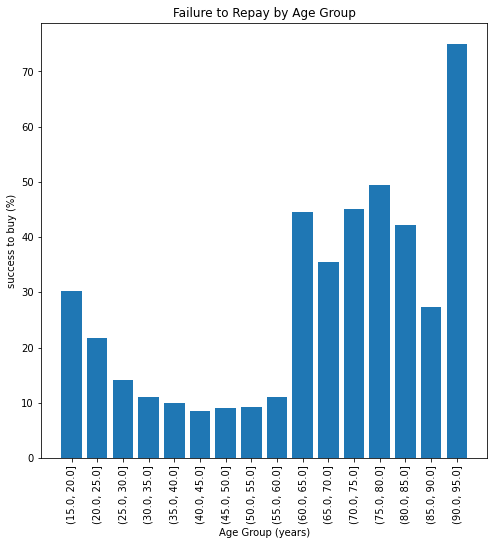

In [30]:
#进一步对年龄进行分层
age_data = app_train[['y', 'age']]

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['age'], bins = np.linspace(15, 95, num = 17))
age_groups  = age_data.groupby('YEARS_BINNED').mean()
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['y'])

# Plot labeling
plt.xticks(rotation = 90); plt.xlabel('Age Group (years)'); plt.ylabel('success to buy (%)')
plt.title('Failure to Repay by Age Group');

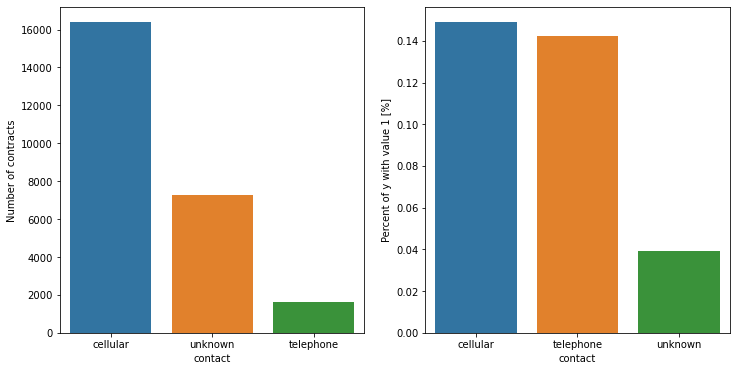

In [31]:
plot_stats('contact')

In [32]:
#特征工程

In [76]:
app_train['sum_loan'] = app_train['housing'] + app_train['loan'] #一个人的贷款数目越多，他购买的意愿就越低

In [77]:
app_test['sum_loan'] = app_test['housing'] + app_test['loan'] 

In [78]:
#对类别特征进行计算购买率
for col in ['job','marital','education','default','housing','loan','contact','poutcome','month']: 
    temp_dict = app_train.groupby([col])['y'].agg(['mean']).reset_index().rename(columns={'mean': col + '_y_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_y_mean'].to_dict()

    app_train[col + '_y_mean'] = app_train[col].map(temp_dict)
    app_test[col + '_y_mean'] = test[col].map(temp_dict)

In [79]:
app_train.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,...,sum_loan,job_y_mean,marital_y_mean,education_y_mean,default_y_mean,housing_y_mean,loan_y_mean,contact_y_mean,poutcome_y_mean,month_y_mean
0,1,43,management,married,tertiary,no,291,yes,no,unknown,...,yesno,0.138973,0.102657,0.150262,0.118018,0.075535,0.126117,0.039280,0.090971,0.065447
1,2,42,technician,divorced,primary,no,5076,yes,no,cellular,...,yesno,0.113417,0.119383,0.084200,0.118018,0.075535,0.126117,0.148923,0.175701,0.195926
2,3,47,admin.,married,secondary,no,104,yes,yes,cellular,...,yesyes,0.117222,0.102657,0.104885,0.118018,0.075535,0.068983,0.148923,0.090971,0.090170
3,4,28,management,single,secondary,no,-994,yes,yes,cellular,...,yesyes,0.138973,0.146430,0.104885,0.118018,0.075535,0.068983,0.148923,0.090971,0.090170
4,5,42,technician,divorced,secondary,no,2974,yes,no,unknown,...,yesno,0.113417,0.119383,0.104885,0.118018,0.075535,0.126117,0.039280,0.090971,0.065447


In [ ]:
#特征筛选

In [80]:
corrs = app_train.corr()

# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [81]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  0


In [82]:
#建模预测
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

In [120]:
#lgb模型模拟
def model(features, test_features, encoding = 'ohe', n_folds = 5):

    
    #Extract the ids
    train_ids = features['ID']
    test_ids = test_features['ID']
    
    # Extract the labels for training
    labels = features['y']
    
    # Remove the ids and target
    features = features.drop(columns = ['ID', 'y'])
    test_features = test_features.drop(columns = ['ID'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=4000, 
                                   objective = 'binary', 
                                   num_leaves = 20,
                                   max_depth = 4,
                                   class_weight = 'balanced',
                                   min_child_weight=0.001,
                                   min_child_samples=29,
                                   feature_fraction = 0.6,
                                   learning_rate = 0.01, 
                                   bagging_fraction = 0.9,
                                   bagging_freq = 3,
                                   reg_alpha = 10, 
                                   reg_lambda = 6,
                                   n_jobs = -1, 
                                   random_state = 50,
                                   min_split_gain = 0)
        
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 400, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submit = pd.DataFrame({'ID': test_ids, 'pred': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submit, feature_importances, metrics

In [118]:
submit,fi,metrics = model(app_train,app_test)

Training Data Shape:  (25317, 52)
Testing Data Shape:  (10852, 52)
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Training until validation scores don't improve for 400 rounds
[200]	train's auc: 0.930126	train's binary_logloss: 0.398101	valid's auc: 0.925175	valid's binary_logloss: 0.411607
[400]	train's auc: 0.93715	train's binary_logloss: 0.336559	valid's auc: 0.929524	valid's binary_logloss: 0.362674
[600]	train's auc: 0.942085	train's binary_logloss: 0.310343	valid's auc: 0.931895	valid's binary_logloss: 0.344839
[800]	train's auc: 0.945942	train's binary_logloss: 0.295138	valid's auc: 0.933111	valid's binary_logloss: 0.334791
[1000]	train's auc: 0.949487	train's binary_logloss: 0.2832

[200]	train's auc: 0.931344	train's binary_logloss: 0.394997	valid's auc: 0.921421	valid's binary_logloss: 0.405409
[400]	train's auc: 0.937502	train's binary_logloss: 0.334987	valid's auc: 0.92523	valid's binary_logloss: 0.356082
[600]	train's auc: 0.941954	train's binary_logloss: 0.31006	valid's auc: 0.927892	valid's binary_logloss: 0.338754
[800]	train's auc: 0.945772	train's binary_logloss: 0.294966	valid's auc: 0.930062	valid's binary_logloss: 0.328604
[1000]	train's auc: 0.949041	train's binary_logloss: 0.28369	valid's auc: 0.931921	valid's binary_logloss: 0.321389
[1200]	train's auc: 0.951914	train's binary_logloss: 0.274489	valid's auc: 0.933164	valid's binary_logloss: 0.315549
[1400]	train's auc: 0.954466	train's binary_logloss: 0.266365	valid's auc: 0.933965	valid's binary_logloss: 0.310918
[1600]	train's auc: 0.956629	train's binary_logloss: 0.259703	valid's auc: 0.934382	valid's binary_logloss: 0.307379
[1800]	train's auc: 0.958464	train's binary_logloss: 0.254169	valid's a

In [119]:
submit.to_csv('submit4.csv', index=False)

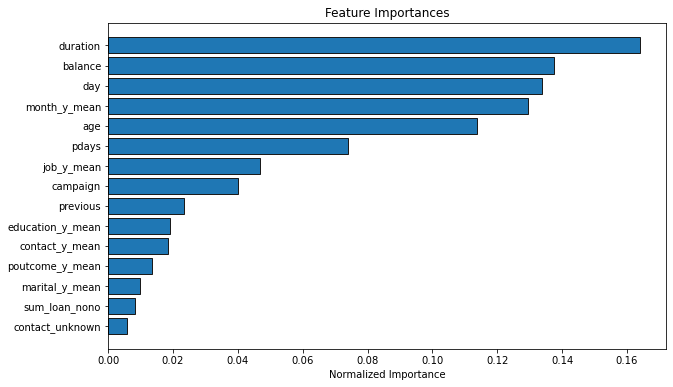

In [90]:
#查看重要参数
def plot_feature_importances(df):
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df
fi_sorted = plot_feature_importances(fi)

In [98]:
#使用网格调参
from sklearn.model_selection import GridSearchCV

X_train = app_train.drop(columns=['ID', 'y'])
y_train = app_train['y']
X_train = pd.get_dummies(X_train)

def get_best_cv_params(learning_rate=0.1, n_estimators=1000, num_leaves=31, max_depth=-1, bagging_fraction=1.0, 
                       feature_fraction=1.0, bagging_freq=0, min_child_weight=0.001, 
                       min_split_gain=0, reg_lambda=0, reg_alpha=0, min_child_samples=21,param_grid=None):
    # 设置5折交叉验证
    cv_fold = StratifiedKFold(n_splits=5, random_state=0, shuffle=True, )
    
    model_lgb = lgb.LGBMClassifier(learning_rate=learning_rate,
                                   n_estimators=n_estimators,
                                   num_leaves=num_leaves,
                                   max_depth=max_depth,
                                   bagging_fraction=bagging_fraction,
                                   feature_fraction=feature_fraction,
                                   bagging_freq=bagging_freq,
                                   min_child_weight=min_child_weight,
                                   min_child_samples=min_child_samples,
                                   min_split_gain=min_split_gain,
                                   reg_lambda=reg_lambda,
                                   reg_alpha=reg_alpha,
                                   n_jobs= 8
                                  )
    grid_search = GridSearchCV(estimator=model_lgb, 
                               cv=cv_fold,
                               param_grid=param_grid,
                               scoring='roc_auc'
                              )
    grid_search.fit(X_train, y_train)

    print('模型当前最优参数为:{}'.format(grid_search.best_params_))
    print('模型当前最优得分为:{}'.format(grid_search.best_score_))

In [102]:
#调整max_depth 和 num_leaves
param_grid = {
    'max_depth': [4,5,6,8],
    'num_leaves': [20,30,40]
}
get_best_cv_params(num_leaves = None,
                   max_depth = None,
                   min_child_weight=0.001,
                   min_child_samples=29,
                   feature_fraction = 0.6,
                   learning_rate = 0.1, 
                   bagging_fraction = 0.9,
                   bagging_freq = 3,
                   reg_alpha = 10, 
                   reg_lambda = 6,
                   n_estimators = 1000,
                   min_split_gain = 0,
                   param_grid=param_grid
                  )

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

In [103]:
#调整max_depth 和 num_leaves,细调
param_grid = {
    'max_depth': [5.5,6,6.5,7],
    'num_leaves': [35,40,45]
}
get_best_cv_params(num_leaves = None,
                   max_depth = None,
                   min_child_weight=0.001,
                   min_child_samples=29,
                   feature_fraction = 0.6,
                   learning_rate = 0.1, 
                   bagging_fraction = 0.9,
                   bagging_freq = 3,
                   reg_alpha = 10, 
                   reg_lambda = 6,
                   n_estimators = 1000,
                   min_split_gain = 0,
                   param_grid=param_grid
                  )

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

In [104]:
#调整min_data_in_leaf 和 min_sum_hessian_in_leaf   
#该步骤主要是防止树过拟合
param_grid = {
'min_child_samples': [28,29,30,31,32],
'min_child_weight': [0.001,0.002]
}
get_best_cv_params(num_leaves = 40,
                   max_depth = 6,
                   min_child_weight=None,
                   min_child_samples=None,
                   feature_fraction = 0.6,
                   learning_rate = 0.1, 
                   bagging_fraction = 0.9,
                   bagging_freq = 3,
                   reg_alpha = 10, 
                   reg_lambda = 6,
                   n_estimators = 1000,
                   min_split_gain = 0,
                   param_grid=param_grid
                  )            

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
模型当前最优参数为:{'min_child_samples': 28, 'min_child_weight': 0.001}
模型当前最优得分为:0.9352033674575206


In [106]:
param_grid = {
'min_child_samples': [26,27,28],
'min_child_weight': [0.0004,0.0005]
}
get_best_cv_params(num_leaves = 40,
                   max_depth = 6,
                   min_child_weight=None,
                   min_child_samples=None,
                   feature_fraction = 0.6,
                   learning_rate = 0.1, 
                   bagging_fraction = 0.9,
                   bagging_freq = 3,
                   reg_alpha = 10, 
                   reg_lambda = 6,
                   n_estimators = 1000,
                   min_split_gain = 0,
                   param_grid=param_grid
                  )     

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

In [108]:
#调整feature_fraction
param_grid = {
'feature_fraction': [0.6, 0.8, 1],
}
get_best_cv_params(num_leaves = 40,
                   max_depth = 6,
                   min_child_weight=0.0005,
                   min_child_samples=28,
                   feature_fraction = None,
                   learning_rate = 0.1, 
                   bagging_fraction = 0.9,
                   bagging_freq = 3,
                   reg_alpha = 10, 
                   reg_lambda = 6,
                   n_estimators = 1000,
                   min_split_gain = 0,
                   param_grid=param_grid
                  )     

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

In [109]:
#调整bagging_fraction和bagging_freq
param_grid = {
'bagging_fraction': [0.8,0.9,1],
'bagging_freq': [2,3,4],
}
get_best_cv_params(num_leaves = 40,
                   max_depth = 6,
                   min_child_weight=0.0005,
                   min_child_samples=28,
                   feature_fraction = 0.6,
                   learning_rate = 0.1, 
                   bagging_fraction = None,
                   bagging_freq = None,
                   reg_alpha = 10, 
                   reg_lambda = 6,
                   n_estimators = 1000,
                   min_split_gain = 0,
                   param_grid=param_grid
                  )   

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 

In [110]:
#调整reg_alpha和reg_lambda
param_grid = {
'reg_alpha': [8,9,10],
'reg_lambda': [4,5,6],
}
get_best_cv_params(num_leaves = 40,
                   max_depth = 6,
                   min_child_weight=0.0005,
                   min_child_samples=28,
                   feature_fraction = 0.6,
                   learning_rate = 0.1, 
                   bagging_fraction = 0.9,
                   bagging_freq = 3,
                   reg_alpha = 10, 
                   reg_lambda = 6,
                   n_estimators = 1000,
                   min_split_gain = 0,
                   param_grid=param_grid
                  )   

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

In [113]:
#调整reg_alpha和reg_lambda 细调
param_grid = {
'reg_alpha': [10,11,12],
'reg_lambda': [6,7,8],
}
get_best_cv_params(num_leaves = 40,
                   max_depth = 6,
                   min_child_weight=0.0005,
                   min_child_samples=28,
                   feature_fraction = 0.6,
                   learning_rate = 0.1, 
                   bagging_fraction = 0.9,
                   bagging_freq = 3,
                   reg_alpha = None, 
                   reg_lambda = None,
                   n_estimators = 1000,
                   min_split_gain = 0,
                   param_grid=param_grid
                  )   

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 